# Modal decomposition of a swirling flow (Part 1)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/zhiyao/Vault/151_MRPOD')
from mrpod import pod_modes

ImportError: cannot import name 'ortho_check' from 'mrpod' (/home/zhiyao/Vault/151_MRPOD/mrpod/__init__.py)

In [2]:
# HIDE CODE
def ortho_check(v1, v2):
    """
    Check the orthogonality of two vectors.
    """
    v1 = np.reshape(v1, np.prod(np.shape(v1)), order='F')
    v2 = np.reshape(v2, np.prod(np.shape(v2)), order='F')

    return v1.T @ v2


def phantomGaussian(size, fwhm=3, center=None, scale=1, offset_x=0):
    """Create a Gaussian shape inside a rectangle"""
    x = np.arange(0, size, 1, float)
    R = size // 2
    y = x[:R, np.newaxis]

    if center is None:
        x0 = y0 = R
    else:
        x0 = center[0]
        y0 = center[1]
    output = np.exp(-4*np.log(2) * ((x-x0/scale-offset_x)**2 + (y-y0/scale)**2) / (fwhm/scale)**2)

    return output


def pvc_1(size=128, R=64, fac_x=0.951662, fac_y=0.9222):
    """Create a precessing vortex core with spatial shift"""
    
    v_x_settings = [[-0.7, 35, 0, 0],
                    [-0.4, 20, 30, -2], [-0.4, 20, -30, -2],
                    [1.1, 32, 26, 28], [1.1, 32, -26, 28],
                    [0.4, 18, 48, 28], [0.4, 18, -48, 28],
                    [-0.6, 30, 50, 54], [-0.8, 30, 30, 48], [-0.6, 30, -50, 54], [-0.8, 30, -30, 48]]
    v_x_settings = np.array(v_x_settings)
    v_x_settings[:,2] = v_x_settings[:,2]*fac_x
    v_x_settings[:,3] = v_x_settings[:,3]*fac_x
    v_x = np.zeros([R, size])
    for i in v_x_settings:
        v_x += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])

    v_y_settings = [[1., 30, 6, 0], [-1., 30, -6, 0], [0.5, 15, 3, 0], [-0.5, 15, -3, 0],
                    [-0.3, 10, 30, 2], [0.3, 10, -30, 2], [-0.5, 10, 30, 12], [0.5, 10, -30, 12],
                    [-1, 30, 25, 40], [1, 30, -25, 40],
                    [0.8, 35, 40, 70], [-0.8, 35, -40, 70],
                    [0.7, 10, 46, 35], [-0.7, 10, -46, 35],
                    [0.3, 10, 43, 20], [-0.3, 10, -43, 20],
                    [-0.1, 30, 60, 10], [0.1, 30, -60, 10]]
    v_y_settings = np.array(v_y_settings)
    v_y_settings[:,2] = v_y_settings[:,2]*fac_y
    v_y_settings[:,3] = v_y_settings[:,3]*fac_y
    v_y = np.zeros([R, size])
    for i in v_y_settings:
        v_y += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])
    return np.array([v_x*1.078, v_y])


def pvc_2(size=128, R=64, fac_x=1, fac_y=1):
    """Create a precessing vortex core
    """
    v_x_settings = [[0.8, 15, 0, -7],
                    [0.4, 20, 38, -8], [0.4, 20, -38, -8],
                    [-0.7, 35, 17, 12], [-0.7, 35, -17, 12],
                    [-0.6, 20, 36, 12], [-0.6, 20, -36, 12],
                    [1.1, 32, 30, 38], [1.1, 32, -30, 38],
                    [-1, 30, 52, 70], [-1, 30, 34, 70], [-1, 30, -52, 70], [-1, 30, -34, 70]]
    v_x_settings = np.array(v_x_settings)
    v_x_settings[:,2] = v_x_settings[:,2]*fac_x
    v_x_settings[:,3] = v_x_settings[:,3]*fac_x
    v_x = np.zeros([R, size])
    for i in v_x_settings:
        v_x += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])

    v_y_settings = [[1, 30, 18, 22], [-1, 30, -18, 22],
                    [-0.3, 10, 5, 0], [0.3, 10, -5, 0],
                    [-0.8, 15, 36, 18], [0.8, 15, -36, 18], [-0.6, 15, 32, 2], [0.6, 15, -32, 2],
                    [0.1, 25, 40, -2], [-0.1, 25, -40, -2],
                    [-1, 30, 30, 50], [1, 30, -30, 50],
                    [1, 35, 53, 64], [-1, 35, -53, 64],
                    [-0.3, 30, 75, 20], [0.3, 30, -75, 20]]
    v_y_settings = np.array(v_y_settings)
    v_y_settings[:,2] = v_y_settings[:,2]*fac_y
    v_y_settings[:,3] = v_y_settings[:,3]*fac_y
    v_y = np.zeros([R, size])
    for i in v_y_settings:
        v_y += i[0]*phantomGaussian(size, fwhm=i[1], center=[i[2]+R, i[3]])
    return np.array([v_x, v_y])


def dataset_stationary(func1, func2, N=400, f=470, add_noise=False, noise_level=0.4):
    """
    Create a dataset using either PVC or TV, with a stationary wave-like motion
    """
    np.random.seed(0)
    t = np.arange(N)*1e-4
    v_array = []
    noise = np.zeros([2, 64, 128])
    for _t in t:
        if add_noise:
            noise = np.random.randn(2, 64, 128)*noise_level
        v_array.append(func1*np.cos(2*np.pi*f*_t) + func2*np.sin(2*np.pi*f*_t)+noise)

    return np.array(v_array)

In [140]:
fac_x = 1.0      # 0.9177561
fac_y = 1         # 0.9222
v1 = pvc_1(fac_x=1.0061951, fac_y=0.88)
v2 = pvc_2(fac_x=1.095, fac_y=0.905)

print(ortho_check(v1, v2))
print(ortho_check(v1, v1))
print(ortho_check(v2, v2))

-1.7928317433302254e-05
2713.9899593723308
2726.8939616270113


In [141]:
# create dataset
dataset = dataset_stationary(v1, v2, N=500)
# reshape
dataset = np.moveaxis(dataset, [1, 2, 3], [3, 1, 2])

In [142]:
# v_array is the pre-generated dataset
pod_results = pod_modes(dataset, num_of_modes=2, normalize_mode=True)

# get the modes and projection coefficients
proj_coeffs = pod_results['proj_coeffs']
modes = pod_results['modes']
eigvals = pod_results['eigvals']
# normalize eigenvalues
eigvals = eigvals/eigvals.sum()*100



[50.11858369 49.88141631]


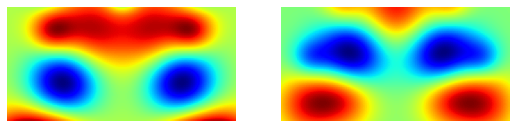

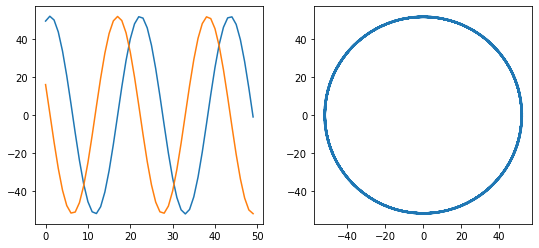

In [143]:
print(eigvals[:2])
_, ax = plt.subplots(1, 2, figsize=(9, 6))
ax[0].imshow(modes[0, :, :, 0], cmap='jet')
ax[0].axis('off')
ax[1].imshow(modes[1, :, :, 0], cmap='jet')
ax[1].axis('off')

_, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(proj_coeffs[0, 100:150])
ax[0].plot(proj_coeffs[1, 100:150])
ax[1].plot(proj_coeffs[0, :], proj_coeffs[1, :])
ax[1].set_aspect(1)
plt.show()